# Zeitserien

Eine sehr spezielle Art von Daten sind sog. *Zeitserien*. Hier wird ein (oder mehrere) Messwert(e) über die Zeit aufgetragen. Die Vorhersage kannst du hier als *zeitliche* Vorhersage betrachten, d.h. es hat eine gewisse Verbindung zur Wettervorhersage - auch das Wetter könnte man als Zeitserie auffassen.

## Datenset laden

Am besten bleibst du gleich beim Wetter. Als Datenset verwendest du die täglichen Minimaltemperaturen in Melbourne. Eine genauere Erklärung über das Datenset und auch über Zeitserien findest du auf https://machinelearningmastery.com/time-series-datasets-for-machine-learning/

Das Datenset lädst du am besten von Github:

In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv",
                 parse_dates=["Date"])
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


Du kannst dir gut einen Überblick verschaffen, indem du das Datenset als Diagramm anzeigen lässt:

<AxesSubplot:xlabel='Date'>

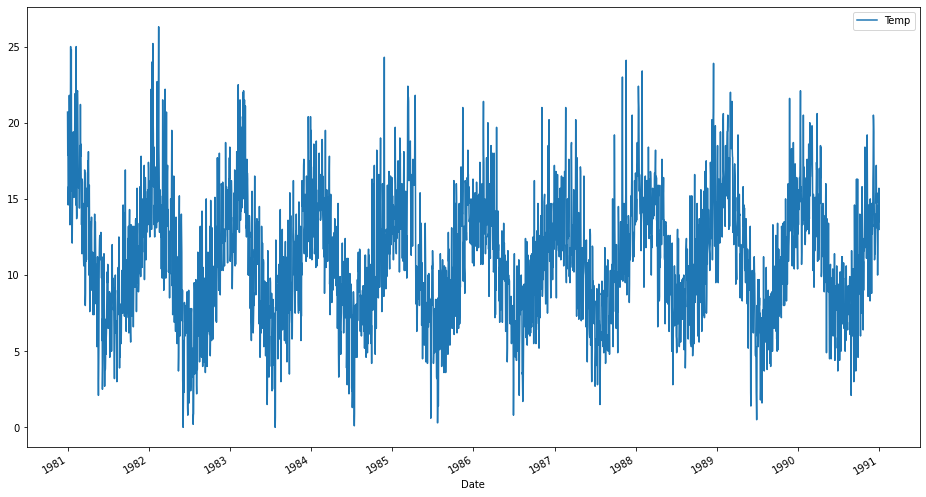

In [2]:
df.set_index("Date").plot(figsize=(16, 9))

## Lineare Regression mit Trainings- und Test-Daten

Zunächst versuchst du es mit linearer Regression abzubilden. Das Verfahren kennst du schon - hier gibt es eine kleine Änderung, weil nur eine Variable als unabhängige Variable zur Verfügung steht. Weil `sklearn` nicht gut mit dem Datum als Variable umgehen kann, nutzt du einfach einen `range`:

In [3]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split([[v] for v in range(len(df))], 
                                                      df["Temp"].values)

Die Regression `fit`test du nur mit den Trainingsdaten

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Fehler berechnen

In diesem Fall reicht es, wenn du einen Score berechnest. Nutze den `r2`-Score:

In [5]:
from sklearn import metrics
metrics.r2_score(y_train, lr.predict(X_train)), metrics.r2_score(y_test, lr.predict(X_test))

(0.00034526775744536664, -0.0015261019689249977)

Selbst der Score der Trainingsdaten sieht gar nicht gut aus. Woran liegt das? Du kannst die Vorhersage durchführen und dir die Daten anzeigen lassen:

In [6]:
df["Predicted Temp"] = lr.predict([[v] for v in range(len(df))])

<AxesSubplot:xlabel='Date'>

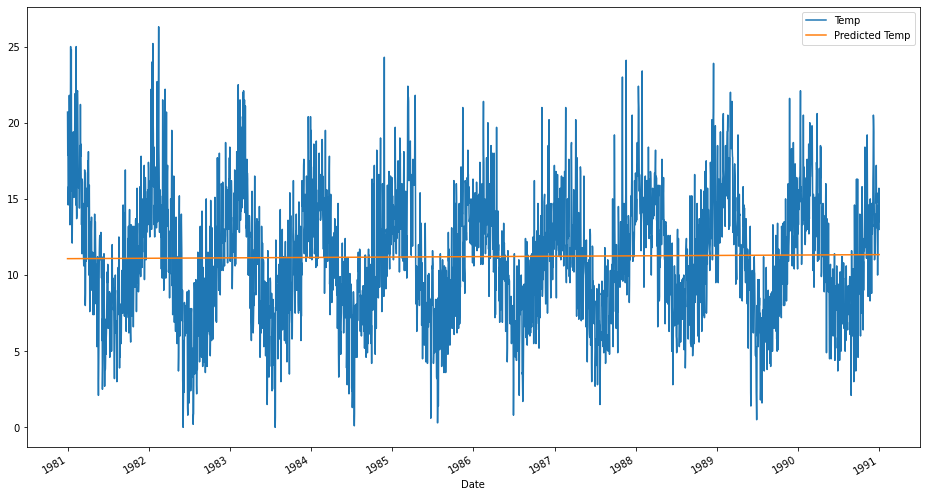

In [7]:
df.set_index("Date")[["Temp", "Predicted Temp"]].plot(figsize=(16, 9))

Die Regression hat einfach den Mittelwert vorhergesagt und die jahrezeitlichen Schwankungen gar nicht berücksichtigt. Das funktioniert so also nicht. Du brauchst ein besseres Verfahren

## Vorhersage von Zeitreihen

Mit `sklearn` kannst du auch mehrdimensionale (oder sog. *multivariate*) Regression durchführen. Es ist gar nicht einfach, die richtigen Features zu finden. In diesem Beispiel benutzt du einfach *alle*:

In [8]:
!pip install prophet

In [9]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


`prophet` erfordert einen `DataFrame`, der aus den beiden Spalten `ds` und `y` besteht:

In [10]:
pdf = pd.DataFrame({"ds": df["Date"].values, 
                    "y": df["Temp"].values})
pdf

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


Anschließend kannst du ein `Prophet`-Objekt instanziieren und die Daten - ganz ähnlich wie bei `sklearn` *fitten*:

In [11]:
m = Prophet()
m.fit(pdf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


`Prophet` hat nun aus den vergangenen Daten gelernt. Du möchtest eine Vorhersage für die zukünftigen Daten durchführen. Dazu erzeugt du einen weiteren `DataFrame`, der von hier ab in die Zukunft geht. Zwei Jahre entsprechen (meistens) 730 Tagen, als Periode gibst du "Tag" (`D`) an:

In [12]:
future = m.make_future_dataframe(periods=730, freq='D')
future

,ds
0,1981-01-01
1,1981-01-02
2,1981-01-03
3,1981-01-04
4,1981-01-05
...,...
4375,1992-12-26
4376,1992-12-27
4377,1992-12-28
4378,1992-12-29


Du siehst, dass der `DataFrame` nur bis zum 30.12.1992 läuft - 1992 war ein Schaltjahr. Das stört dich (hier) nicht.

Jetzt kannst du `Prophet` die Vorhersage für die Zukunft durchführen und dir die letzten Ergebnisse anzeigen lassen:

In [13]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4375,1992-12-26,14.425128,10.770459,18.086566
4376,1992-12-27,14.389570,10.746352,17.787931
4377,1992-12-28,14.585417,11.280497,17.999013
4378,1992-12-29,14.751374,11.202364,18.170308
4379,1992-12-30,14.908053,11.552381,18.365705


Das sieht gut aus.

Ein großer Vorteil von `Prophet` sind die Visualisierungen, die es bereits eingebaut hat:

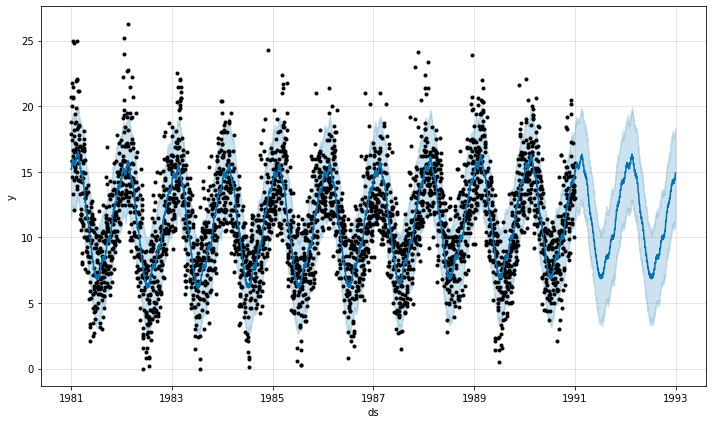

In [14]:
fig1 = m.plot(forecast)

Die Vorhersage sieht gut aus, auch die Interpolation der vergangenen Werte.

`Prophet` kann noch mehr und auch längerfristige Trends anzeigen sowie Periodiziäten:

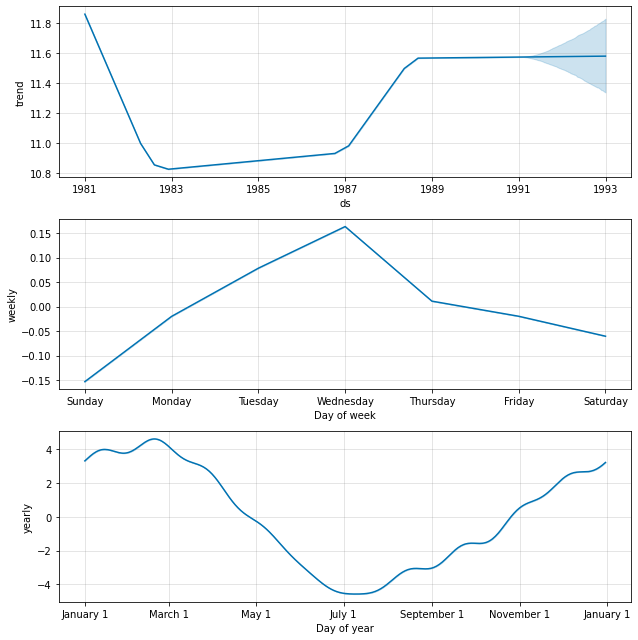

In [15]:
fig2 = m.plot_components(forecast)

Ab 1983 war ein leichter Temperaturanstieg zu beobachten, der sich 1987 verschärft hat. Mittwochs war es im Mittel am wärmsten, aber der Unterschied von 0,3°C ist nicht signifikant. Eher schon der Monatstrend, den du beobachten kannst. Auf der Südhalbkugel ist es im Juli am kältesten, immerhin 8°C vergleichen mit Februar. Verkehrte Welt.

## Vorhersage von Zeitserien

Wie du gesehen hast, funktioniert eine lineare Regression bei Zeitserien (oft) nicht gut. Das liegt an Periodizitäten und daran, dass Daten aus der unmittelbaren und längeren Vergangenheit berücksichtigt werden müssen. Das macht die Vorhersage zu einer echten Kunst.

Es gibt auch sog. ARIMA-Modelle, mit denen man gute Ergebnisse erzielen kann. Diese haben wir hier nicht betrachtet, da die Machine Learning-Modelle in der Zwischenzeit mindestens genauso gut funktionieren und nicht so komplex getuned werden müssen.

`Prophet` macht seine Sache sehr gut. Im Hintergrund werkeln dabei verschiedene (auch komplexe) Verfahren wie LSTMs usw., die du aber gar nicht zu Gesicht bekommst. Dafür sind die Ergebnisse wirklich gut!